In [1]:
import pandas as pd
import gpytorch
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, KFold
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
dfFeats = pd.read_excel('features.xlsx').iloc[:, 3:]
dfEnumFeats = pd.read_excel('UnknownFeatures.xlsx').iloc[:, 3:]
dfLNMO = pd.read_excel('MeasuredPerformance.xlsx')

In [3]:
# Define the model
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_X, train_Y, likelihood):
        super(GPModel, self).__init__(train_X, train_Y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            #gpytorch.kernels.RBFKernel(ard_num_dims=X_train.shape[1]))
            gpytorch.kernels.MaternKernel(ard_num_dims=X_train.shape[1]))
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

average_mae_train = {}
average_mae_test = {}

average_rmse_train = {}
average_rmse_test = {}

std_mae_train = {}
std_mae_test = {}

std_rmse_train = {}
std_rmse_test = {}

X_train_best = {}
X_test_best = {}
y_train_best = {}
y_test_best = {}
for i, prop in enumerate(['FinImpedance', 'DeltaImpedance', 'FinSpcCap']):
    y = dfLNMO[prop]
    X = deepcopy(dfFeats)

    # Perform k-fold cross validation
    k_fold = 10
    
    # Split the data into k equal parts
    kf = KFold(n_splits=k_fold, shuffle=True, random_state=42)
    mae_train_list = []
    mae_test_list = []  
    rmse_train_list = []
    rmse_test_list = []
    
    best_score = float('inf')
    best_model = None
    
    # Loop over folds
    for train_index, test_index in kf.split(X):
        # Split train-test
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Scale the data
        sc = StandardScaler()
        X_train = sc.fit_transform(X_train)
        y_train = np.array(y_train)
        X_train = torch.tensor(X_train, dtype=torch.float32)
        y_train = torch.tensor(y_train, dtype=torch.float32)
        
        X_test = sc.transform(X_test)
        y_test = np.array(y_test)
        X_test = torch.tensor(X_test, dtype=torch.float32)
        y_test = torch.tensor(y_test, dtype=torch.float32)

        # Set up the model and likelihood
        likelihood = gpytorch.likelihoods.GaussianLikelihood()
        model = GPModel(X_train, y_train, likelihood)
        
        # Find optimal hyperparameters
        model.train()
        likelihood.train()

        optimizer = Adam([{'params': model.parameters()}], lr=0.1)
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

        training_iterations = 6000
    
        loss_list = []
        
        for j in range(training_iterations):
            optimizer.zero_grad()
            output = model(X_train)
            loss = -mll(output, y_train)
            loss.backward()
            optimizer.step()
            loss_list.append(loss.item())

        model.eval()
        likelihood.eval()

        # Make predictions on training set
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            observed_pred = likelihood(model(X_train))
            y_pred_train = observed_pred.mean
            std_train = observed_pred.stddev
        
        # Calculate metrics on training set
        mae_train = mean_absolute_error(y_train, y_pred_train)
        rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
        r2_train = round(r2_score(y_train, y_pred_train), 2)
        
        mae_train_list.append(mae_train)
        rmse_train_list.append(rmse_train)
        
        # Make predictions on test set
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            observed_pred = likelihood(model(X_test))
            y_pred_test = observed_pred.mean
            std_test = observed_pred.stddev

        # Calculate metrics on test set
        mae_test = mean_absolute_error(y_test, y_pred_test)
        rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
        r2_test = round(r2_score(y_test, y_pred_test), 2)

        mae_test_list.append(mae_test)
        rmse_test_list.append(rmse_test)
        
        if mae_test < best_score:
            best_score = mae_test
            best_model = model
            X_train_best[prop] = X_train
            X_test_best[prop] = X_test
            y_train_best[prop] = y_train
            y_test_best[prop] = y_test
            
            
    torch.save(best_model.state_dict(), f'best_model_{prop}.pth')
    torch.save(likelihood.state_dict(), f'best_likelihood_{prop}.pth')
    # Print average metrics from k-fold cross validation
    print(prop)
    average_mae_test[prop] = np.mean(mae_test_list)
    std_mae_test[prop] = np.std(mae_test_list)
    average_mae_train[prop] = np.mean(mae_train_list)
    std_mae_train[prop] = np.std(mae_train_list)
    average_rmse_test[prop] = np.mean(rmse_test_list)
    std_rmse_test[prop] = np.std(rmse_test_list)
    average_rmse_train[prop] = np.mean(rmse_train_list)
    std_rmse_train[prop] = np.std(rmse_train_list)
    
    print('Test:')
    print(f'Average MAE: {average_mae_test[prop]:.0f} ± {std_mae_test[prop]:.0f}')
    print(f'Average RMSE: {average_rmse_test[prop]:.0f} ± {std_rmse_test[prop]:.0f}')

    print('Train:')
    print(f'Average MAE: {average_mae_train[prop]:.0f} ± {std_mae_train[prop]:.0f}')
    print(f'Average RMSE: {average_rmse_train[prop]:.0f} ± {std_rmse_train[prop]:.0f}')

FinImpedance
Test:
Average MAE: 20 ± 11
Average RMSE: 24 ± 14
Train:
Average MAE: 11 ± 1
Average RMSE: 15 ± 1
DeltaImpedance
Test:
Average MAE: 15 ± 8
Average RMSE: 19 ± 10
Train:
Average MAE: 8 ± 1
Average RMSE: 11 ± 1
FinSpcCap
Test:
Average MAE: 11 ± 5
Average RMSE: 14 ± 7
Train:
Average MAE: 4 ± 0
Average RMSE: 5 ± 0


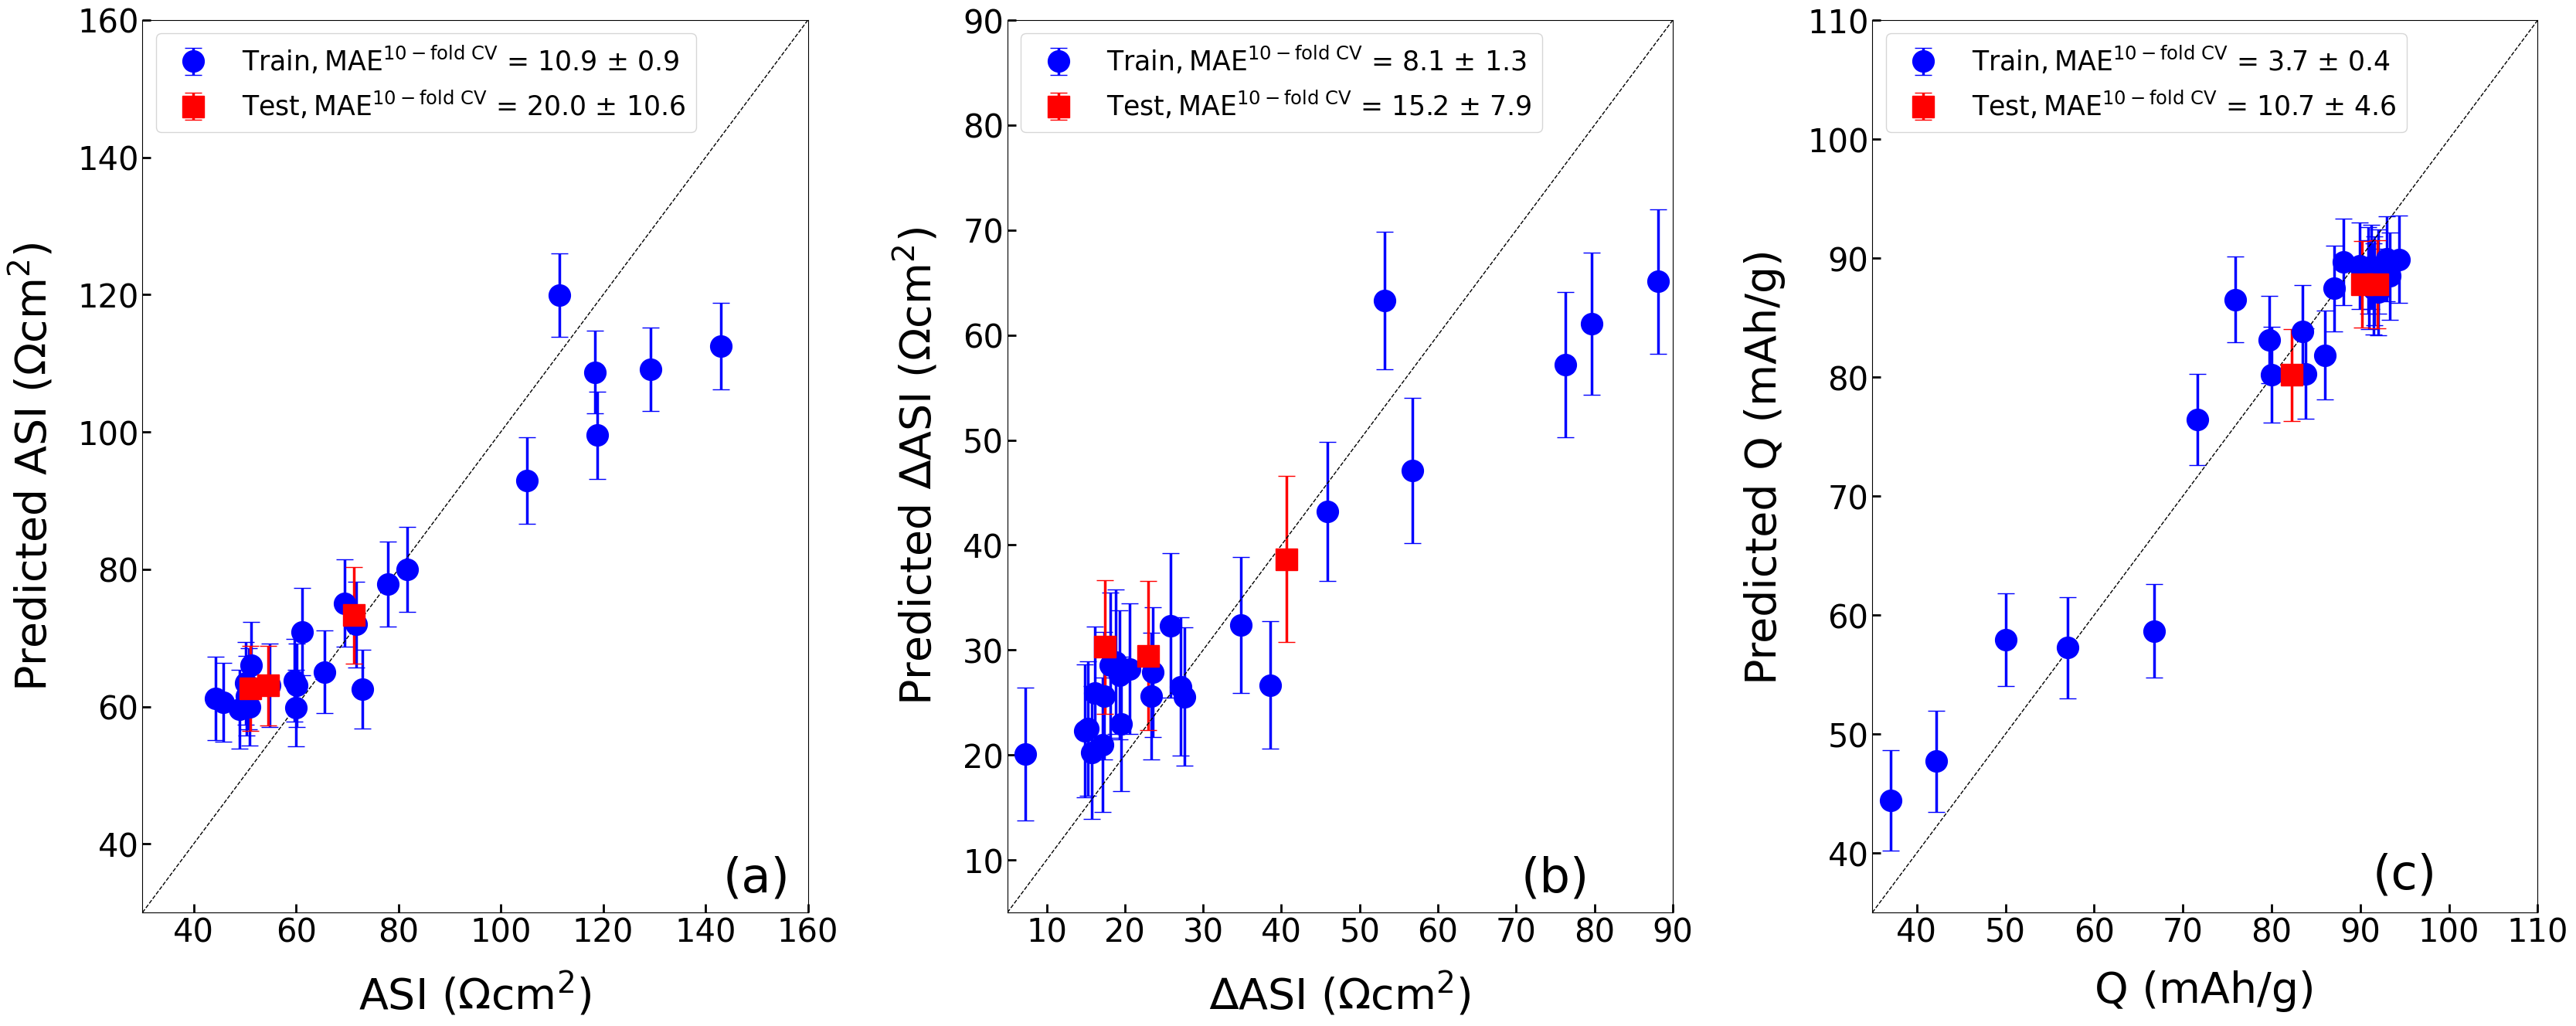

In [4]:
# Plot results
fig = plt.figure(figsize=(40, 15))
fig.subplots_adjust(wspace=0.3, hspace=0.3) # Add more padding between subplots
train_cl = 'blue'
test_cl = 'red'

for i, prop in enumerate(['FinImpedance', 'DeltaImpedance', 'FinSpcCap']):
    if prop=='FinImpedance':
        propName = 'ASI'
        cl = 'red'
        unit = '$\u03A9$cm$^2$'
    elif prop=='DeltaImpedance':
        propName = '∆ASI'
        cl = 'green'
        unit = '$\u03A9$cm$^2$'
    elif prop=='FinSpcCap':
        propName = 'Q'
        cl = 'blue'
        unit = 'mAh/g'
    
    # Load the saved model and likelihood state dictionaries
    model_state_dict = torch.load(f'best_model_{prop}.pth')
    likelihood_state_dict = torch.load(f'best_likelihood_{prop}.pth')
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    
    # Create an instance of the model and likelihood using the loaded state dictionaries
    model = GPModel(X_train_best[prop], y_train_best[prop], likelihood)
    
    model.load_state_dict(model_state_dict)
    likelihood.load_state_dict(likelihood_state_dict)

    # Set the model and likelihood in evaluation mode
    model.eval()
    likelihood.eval()

    # Make predictions on training set
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred = likelihood(model(X_train_best[prop]))
        y_pred_train = observed_pred.mean
        std_train = observed_pred.stddev

    # Make predictions on test set
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred = likelihood(model(X_test_best[prop]))
        y_pred_test = observed_pred.mean
        std_test = observed_pred.stddev
        
    #Plot predictions
    axisLabelSize = 40
    tickLabelSize = 30
    ax = fig.add_subplot(1, 3, i+1)  
    markerSize = 20
    
    ax.tick_params(which='major', direction='in', length=8, width=2, left='on', bottom='on', colors='k')
    ax.tick_params(which='minor', direction='in', length=4, width=1, left='on', bottom='on', colors='k')
    for label1 in ax.xaxis.get_ticklabels(): # label is a Text instance
        label1.set_fontsize(tickLabelSize)
    for label2 in ax.yaxis.get_ticklabels(): # label is a Text instance
        label2.set_fontsize(tickLabelSize)
    plt.errorbar(y_train_best[prop], y_pred_train, yerr= std_train, fmt='o', capsize=8, c=train_cl, alpha=1., 
                ms=markerSize, lw=2.5, label=r"$\rm Train, MAE^{10-fold \ CV}$ = "+str(round(average_mae_train[prop],1))+" ± "+str(round(std_mae_train[prop],1)))#"R$^2$ = "+str(r2_train)+", RMSE = "+str(round(rmse_train,2))+", MAE = "+str(round(mae_train,2)))
    plt.errorbar(y_test_best[prop], y_pred_test, yerr= std_test, fmt='s', capsize=8, c=test_cl, alpha=1., 
                ms=markerSize, lw=2.5, label=r"$\rm Test, MAE^{10-fold \ CV}$ = "+str(round(average_mae_test[prop],1))+" ± "+str(round(std_mae_test[prop],1)))#"R$^2$ = "+str(r2_test)+", RMSE = "+str(round(rmse_test,2))+", MAE = "+str(round(mae_test,2)))
    
    plt.xlabel(propName + ' ('+unit+')', fontsize=axisLabelSize, labelpad=20)
    plt.ylabel('Predicted '+propName + ' ('+unit+')', fontsize=axisLabelSize, labelpad=20)
    plt.legend(loc='upper left', fontsize=25)
    if prop=='FinImpedance':
        ax.text(150, 33, '(a)', ha='center', fontsize=axisLabelSize+5)
        ax.set_ylim([30, 160])
        ax.set_xlim([30, 160])
        plt.plot([30, 160],[30, 160], color='black', linestyle='--', linewidth=1.)
    elif prop=='DeltaImpedance':
        ax.text(75., 7, '(b)', ha='center', fontsize=axisLabelSize+5)
        ax.set_ylim([5, 90])
        ax.set_xlim([5, 90])
        plt.plot([5, 90],[5, 90], color='black', linestyle='--', linewidth=1.)
    elif prop=='FinSpcCap':
        ax.text(95., 37, '(c)', ha='center', fontsize=axisLabelSize+5)
        ax.set_ylim([35, 110])
        ax.set_xlim([35, 110])
        plt.plot([35, 110],[35, 110], color='black', linestyle='--', linewidth=1.)


In [5]:
# Make predictions on unknown dataset  
X_newAdd = sc.transform(dfEnumFeats)
for prop in ['FinImpedance', 'DeltaImpedance', 'FinSpcCap']:
    # Load the saved model and likelihood state dictionaries
    model_state_dict = torch.load(f'best_model_{prop}.pth')
    likelihood_state_dict = torch.load(f'best_likelihood_{prop}.pth')
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    
    # Create an instance of the model and likelihood using the loaded state dictionaries
    model = GPModel(X_train_best[prop], y_train_best[prop], likelihood)
    
    
    model.load_state_dict(model_state_dict)
    likelihood.load_state_dict(likelihood_state_dict)

    # Set the model and likelihood in evaluation mode
    model.eval()
    likelihood.eval()

    # Make predictions on new data
    with torch.no_grad():
        test_x = torch.tensor(X_newAdd, dtype=torch.float32)  # Sample input data
        predictions = likelihood(model(test_x))  # Predict the output
        y_pred_newAdd = predictions.mean  # Get the mean predictions
        sigma_newAdd = predictions.variance  # Get the predictive variance
    if prop=='FinImpedance':    
        resListFinImp = [int(val) for val in y_pred_newAdd.tolist()]
        resListFinImp_sigma = [int(val) for val in sigma_newAdd.tolist()]
    elif prop=='IniImpedance':
        resListIniImp = [int(val) for val in y_pred_newAdd.tolist()]
        resListIniImp_sigma = [int(val) for val in sigma_newAdd.tolist()]
    elif prop=='FinSpcCap':
        resListFinSpcCap = [int(val) for val in y_pred_newAdd.tolist()]
        resListFinSpcCap_sigma = [int(val) for val in sigma_newAdd.tolist()]
    elif prop=='DeltaImpedance':
        resListDeltaImp = [int(val) for val in y_pred_newAdd.tolist()]
        resListDeltaImp_sigma = [int(val) for val in sigma_newAdd.tolist()]

In [6]:
dfComboRes = pd.read_excel('UnknownFeatures.xlsx').iloc[:,:3]

dfComboRes['FinImpedance'] = resListFinImp
dfComboRes['FinImpedance_std'] = resListFinImp_sigma

dfComboRes['DeltaImpedance'] = resListDeltaImp
dfComboRes['DeltaImpedance_std'] = resListDeltaImp_sigma

dfComboRes['FinSpcCap'] = resListFinSpcCap
dfComboRes['FinSpcCap_std'] = resListFinSpcCap_sigma

dfComboRes.to_excel('predictedPerformance.xlsx', index=None)